# Imports & Setup

In [1]:
from pathlib import Path
import os

import numpy as np
import pandas as pd

import mlflow

mlflow.sklearn.autolog(
    disable=False,
    exclusive=False,
    log_models=False,
    log_input_examples=True,
)
logged_models_dir = "modelo"

import joblib

memory = joblib.Memory("Memory", verbose=2)

from sklearn.linear_model import SGDClassifier
from sklearn.datasets import fetch_openml, load_digits
from sklearn.model_selection import (
    cross_validate,
    cross_val_score,
    cross_val_predict,
    train_test_split,
    PredefinedSplit,
    StratifiedShuffleSplit,
)

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    recall_score,
    precision_score,
    f1_score,
    precision_recall_curve,
    classification_report,
)

from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    RandomizedSearchCV,
    # HalvingRandomSearchCV,
)

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler


from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import uniform


from data_mastor import mastor as ms
import importlib

importlib.reload(ms)


<module 'data_mastor.mastor' from '/home/nikley/Projects/data-mastor/src/data_mastor/mastor.py'>

# Setup

In [2]:
res_all = pd.DataFrame()  # store all results here


# Load data

In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1, cache=True, as_frame=False)

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]


## SVC

In [4]:
experiment_name = "SVC"
mlflow.set_experiment(experiment_name)


<Experiment: artifact_location='file:///home/nikley/Projects/dataset-drilling/MNIST/mlruns/2', experiment_id='2', lifecycle_stage='active', name='SVC', tags={}>

In [5]:
def find_runs(run_name=None, no_children=False, **search_runs_kwargs):

    if run_name is not None:

        filter_string = f"tags.`mlflow.runName` = '{run_name}'"
    else:
        filter_string = ""

    df = mlflow.search_runs(filter_string=filter_string, **search_runs_kwargs)

    if no_children and ("tags.mlflow.parentRunId" in df.columns):
        df = df[df["tags.mlflow.parentRunId"].isna()]

    return df


run_name = "bozz"
experiment_names = []
find_runs(run_name=run_name, experiment_names=experiment_names)


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.training_accuracy_score,metrics.training_recall_score,metrics.training_f1_score,metrics.training_score,...,params.n_jobs,params.verbose,tags.estimator_class,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.log-model.history,tags.mlflow.user,tags.mlflow.runName,tags.estimator_name,tags.mlflow.datasets
0,12d57f4ac2024e60a7a62eb845e8395d,2,FAILED,file:///home/nikley/Projects/dataset-drilling/...,2022-06-18 10:44:13.417000+00:00,2022-06-18 10:44:20.537000+00:00,1.0,1.0,1.0,1.0,...,8,0,sklearn.model_selection._search.GridSearchCV,/home/nikley/miniconda3/lib/python3.9/site-pac...,LOCAL,"[{""run_id"": ""12d57f4ac2024e60a7a62eb845e8395d""...",nikley,bozz,GridSearchCV,None
1,a87f7e4f910a48258afc01f03b121c7e,2,FINISHED,file:///home/nikley/Projects/dataset-drilling/...,2022-06-18 10:40:54.731000+00:00,2022-06-18 10:41:04.269000+00:00,1.0,1.0,1.0,1.0,...,8,0,sklearn.model_selection._search.GridSearchCV,/home/nikley/miniconda3/lib/python3.9/site-pac...,LOCAL,"[{""run_id"": ""a87f7e4f910a48258afc01f03b121c7e""...",nikley,bozz,GridSearchCV,"[{""name"":""a1ee71132db19371e41de52c0993e9e5"",""h..."


In [6]:
def get_last_run_search_info(
    run_name=None, no_children=True, **search_run_kwargs
):

    df = mlflow.search_runs(**search_run_kwargs)

    df = find_runs(
        run_name=run_name, no_children=no_children, **search_run_kwargs
    )

    if len(df) == 0:
        print("Such a run does not exist")

    if len(df) > 1:
        print("Multiple such runs exist")

    if len(df) > 0:
        last_run_search_info = df.sort_values(
            "start_time", ascending=True
        ).iloc[-1]
    else:
        last_run_search_info = None

    return last_run_search_info


# last_run_info = get_last_run_of_experiment("SVC")
last_run_search_info = get_last_run_search_info(
    experiment_names=[experiment_name]
)
last_run_search_info


Multiple such runs exist


run_id                                      12d57f4ac2024e60a7a62eb845e8395d
experiment_id                                                              2
status                                                                FAILED
artifact_uri               file:///home/nikley/Projects/dataset-drilling/...
start_time                                  2022-06-18 10:44:13.417000+00:00
                                                 ...                        
tags.mlflow.runName                                                     bozz
tags.estimator_name                                             GridSearchCV
tags.mlflow.autologging                                                 None
tags.mlflow.parentRunId                                                 None
tags.mlflow.datasets                                                    None
Name: 0, Length: 67, dtype: object

In [7]:
last_run_id = last_run_search_info.run_id
last_run = mlflow.get_run(last_run_id)
last_run


<Run: data=<RunData: metrics={'best_cv_score': 0.8786109827417585,
 'training_accuracy_score': 1.0,
 'training_f1_score': 1.0,
 'training_precision_score': 1.0,
 'training_recall_score': 1.0,
 'training_score': 1.0}, params={'best_classifier__C': '0.5',
 'best_classifier__kernel': 'linear',
 'cv': '2',
 'error_score': 'nan',
 'estimator': "Pipeline(steps=[('scaler', StandardScaler()), ('classifier', "
              'SVC())])',
 'n_jobs': '8',
 'param_grid': "[{'classifier__kernel': ['linear', 'poly', 'rbf'], "
               "'classifier__C': [0.5, 1, 2]}]",
 'pre_dispatch': '2*n_jobs',
 'refit': 'True',
 'return_train_score': 'False',
 'scoring': 'f1_macro',
 'verbose': '0'}, tags={'estimator_class': 'sklearn.model_selection._search.GridSearchCV',
 'estimator_name': 'GridSearchCV',
 'mlflow.log-model.history': '[{"run_id": "12d57f4ac2024e60a7a62eb845e8395d", '
                             '"artifact_path": "modelo", "utc_time_created": '
                             '"2022-06-18 10:44

In [8]:
bof = mlflow.search_runs()
run_ids = set(bof["run_id"])
run_ids


{'12d57f4ac2024e60a7a62eb845e8395d',
 '1f4f19e727f04b7ea00c1f8100c7660a',
 '410602f5f27345089ba88145d7559162',
 '486931712d0d45448ba0ca89785abd6f',
 '6ab4f6a00d2e4757b9b241151031a50a',
 'a87f7e4f910a48258afc01f03b121c7e',
 'ac0f291aebcd4fbeb187cca25baa0cd6',
 'c7d03d5cb52e455ea4d6b46a687239a4'}

In [9]:
def delete_duplicate_runs(
    run_name=None,
    no_children=False,
    parameter_names=None,
    keep=0,
    **search_runs_kwargs
):

    if run_name is not None:
        df = find_runs(
            run_name=run_name, no_children=no_children, **search_runs_kwargs
        )
    else:
        df = find_runs(no_children=no_children, **search_runs_kwargs)

    df = df.sort_values("start_time", ascending=False)

    if parameter_names is not None:
        parameter_column_names = ["params." + _ for _ in parameter_names]
    duplicates = df.duplicated(subset=parameter_column_names)

    duplicates_to_delete = df[duplicates].iloc[keep:]

    ids_to_delete = duplicates_to_delete["run_id"].tolist()
    for id_ in ids_to_delete:
        mlflow.delete_run(run_id=id_)

    return duplicates_to_delete


# df = delete_duplicate_runs(parameter_names=["estimator", "param_grid"], keep=0)
# df


In [10]:
run_name = "bozz"
train_now = True


last_run_search_info = get_last_run_search_info(
    experiment_names=[experiment_name]
)
if last_run_search_info is not None:
    artifact_uri = last_run_search_info.artifact_uri
    model_path = str(Path(artifact_uri) / Path("model"))
    print(f"Last run id: {last_run_search_info.run_id}")

    try:
        model = mlflow.sklearn.load_model(model_path)
    except OSError:
        print(f"{model_path} is not a model. Will train a new model now.")
        train_now = True
    except Exception as exc:
        print(exc)


if train_now:
    with mlflow.start_run(run_name=run_name) as run:
        artifact_uri = run.info.artifact_uri
        model_path = str(Path(artifact_uri) / Path("model"))
        print(f"Run id: {run.info.run_id}")

        # Define model
        pipeline = Pipeline(
            [("scaler", StandardScaler()), ("classifier", SVC())]
        )
        parameters = [
            {
                "classifier__kernel": ["linear", "poly", "rbf"],
                "classifier__C": [0.5, 1, 2],
            },
        ]
        model = GridSearchCV(
            pipeline, parameters, cv=2, scoring="f1_macro", n_jobs=8
        )

        print("TRAINING")
        ind = ms.subset_indices(y_train, ratio=0.025)
        X_train_subset = X_train[ind]
        y_train_subset = y_train[ind]
        print(f"Num training samples: {len(X_train_subset)}")

        model.fit(X_train_subset, y_train_subset)

        print(os.listdir(artifact_uri[7:]))
        model_uri = artifact_uri + "/model"
        model_info = mlflow.sklearn.log_model(
            model, logged_models_dir, registered_model_name="berb"
        )
        model_uri = model_info.model_uri
        registered_model_name = "boskley"

        res = ms.cv_results_df(model.cv_results_)
        res.insert(0, "param_classifier", "SVC")
        mlflow.log_dict(res.to_html(), "search_cv_mean_test_scores.html")

        print("EVALUATION")
        ind = ms.subset_indices(y_test, ratio=0.2)
        X_test_subset = X_test[ind]
        y_test_subset = y_test[ind]
        print(f"Num evaluation samples: {len(X_test_subset)}")

        eval_on_test = mlflow.evaluate(
            model_uri,
            data=X_test_subset,
            targets=y_test_subset,
            model_type="classifier",
            evaluator_config={
                "log_model_explainability": False,
                "explainability_nsamples": 2000,
            },
            evaluators=None,
        )


delete_old_runs_with_same_name = False
if delete_old_runs_with_same_name:
    delete_duplicate_runs(parameter_names=["estimator", "param_grid"], keep=0)


res


Last run id: a87f7e4f910a48258afc01f03b121c7e
Run id: 12d57f4ac2024e60a7a62eb845e8395d
TRAINING
Num training samples: 1500


2022/06/18 13:44:18 INFO mlflow.sklearn.utils: Logging the 5 best runs, 4 runs will be omitted.


['training_confusion_matrix.png', 'cv_results.csv']


/home/nikley/miniconda3/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


MlflowException: Model Registry features are not supported by the store with URI: 'file:///home/nikley/Projects/dataset-drilling/MNIST/mlruns'. Stores with the following URI schemes are supported: ['databricks', 'http', 'https', 'postgresql', 'mysql', 'sqlite', 'mssql'].

In [71]:
modelaki = mlflow.pyfunc.load_model(
    "/home/nikley/Projects/dataset-drilling/MNIST/mlruns/2/06be5778859a4c769c596bacc9ad0c5f/artifacts/best_estimator/"
)
modelaki


mlflow.pyfunc.loaded_model:
  artifact_path: best_estimator
  flavor: mlflow.sklearn
  run_id: 06be5778859a4c769c596bacc9ad0c5f

In [72]:
moda_uri = artifact_uri + "/best_estimator"
moda_uri


'file:///home/nikley/Projects/dataset-drilling/MNIST/mlruns/2/9234dcbd490240cd89c3c1866f3747d5/artifacts/best_estimator'

In [73]:
moda_path = artifact_uri / Path("best_estimator")
moda_path


PosixPath('file:/home/nikley/Projects/dataset-drilling/MNIST/mlruns/2/9234dcbd490240cd89c3c1866f3747d5/artifacts/best_estimator')

In [74]:
model_path


'file:/home/nikley/Projects/dataset-drilling/MNIST/mlruns/2/9234dcbd490240cd89c3c1866f3747d5/artifacts/model'

eval_on_test = mlflow.evaluate(
    artifact_uri+"/model",
    data=X_test_subset,
    targets=y_test_subset,
    model_type="classifier",
    evaluator_config={
        "log_model_explainability" : False,
        "explainability_nsamples": 1300,
    },
    evaluators=None,
)
eval_on_test

In [ ]:
eval_on_test.artifacts.

SyntaxError: invalid syntax (2336099149.py, line 1)

In [ ]:
os.listdir(
    "/home/nikley/Projects/dataset-drilling/MNIST/mlruns/2/cd9bf753faed470ea70b38ca6d4adce9/artifacts/"
)


['search_cv_mean_test_scores.html']

all svcs with linear kernel have the same test score, independently of C

## LinearSVC

In [ ]:
pipeline.set_params(classifier=LinearSVC())


parameters = [
    {
        # "classifier__tol": [1e-4, 1e-3, 1e-2, 1e-1],
        # "classifier__C":uniform(loc=0, scale=10),
        "classifier__C": [0.5, 1, 2, 4, 8, 16],
    },
]

search = GridSearchCV(pipeline, parameters, cv=5, scoring="f1_macro", n_jobs=8)

search.fit(X_train_subset, y_train_subset)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier', LinearSVC())]),
             n_jobs=8, param_grid=[{'classifier__C': [0.5, 1, 2, 4, 8, 16]}],
             scoring='f1_macro')

In [ ]:
res_svc = ms.cv_results_df(search.cv_results_)
res_svc


,param_classifier__C,mean_test_score
0,0.5,0.697136
1,1,0.696970
2,2,0.696970
3,4,0.693748
4,8,0.693748
5,16,0.693748


In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

parameters = [
    {
        "classifier__C": [1],
    },
]

search = GridSearchCV(
    pipeline,
    parameters,
    cv=split,
    verbose=4,
    scoring="f1_macro",
    n_jobs=8,
    return_train_score=True,
)

num_examples = 3000
search.fit(X_train[:num_examples], y_train[:num_examples])

res_svc = ms.cv_results_df(search.cv_results_)
res_svc


Fitting 1 folds for each of 1 candidates, totalling 1 fits


/home/nikley/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/1] END classifier__C=1;, score=(train=1.000, test=0.830) total time=   4.4s


/home/nikley/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,param_classifier__C,mean_test_score
0,1,0.830406


In [ ]:
pd.DataFrame(search.cv_results_)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,1.108263,0.0,0.001558,0.0,1,{'classifier__C': 1},0.789027,0.789027,0.0,1,1.0,1.0,0.0


In [ ]:
pipeline.set_params(classifier=LinearSVC())


parameters = [
    {
        # "classifier__tol": [1e-4, 1e-3, 1e-2, 1e-1],
        # "classifier__C":uniform(loc=0, scale=10),
        "classifier__C": [0.5, 1, 2],
    },
]

search = GridSearchCV(pipeline, parameters, cv=5, scoring="f1_macro", n_jobs=8)

search.fit(X_train, y_train)

res_svc = ms.cv_results_df(search.cv_results_)
res_svc


/home/nikley/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nikley/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nikley/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nikley/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nikley/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nikley/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarni

,param_classifier__C,mean_test_score
0,0.5,0.904773
1,1,0.901959
2,2,0.893967


## SGD

In [ ]:
pipeline.set_params(classifier=SGDClassifier())


parameters = [
    {
        "classifier__loss": ["hinge", "log_loss", "modified_huber"],
        # "classifier__C":uniform(loc=0, scale=10),
        # "classifier__C": [0.5, 1, 2, 4, 8,16],
        "classifier__alpha": [0.0001, 0.001, 0.01],
    },
]

search = GridSearchCV(pipeline, parameters, cv=5, scoring="f1_macro", n_jobs=8)

search.fit(X_train_subset, y_train_subset)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier', SGDClassifier())]),
             n_jobs=8,
             param_grid=[{'classifier__alpha': [0.0001, 0.001, 0.01],
                          'classifier__loss': ['hinge', 'log_loss',
                                               'modified_huber']}],
             scoring='f1_macro')

In [ ]:
res_svc = ms.cv_results_df(search.cv_results_)
res_svc


,param_classifier__alpha,param_classifier__loss,mean_test_score
7,0.01,log_loss,0.815611
6,0.01,hinge,0.812618
4,0.001,log_loss,0.808904
5,0.001,modified_huber,0.804716
8,0.01,modified_huber,0.802650
3,0.001,hinge,0.800995
0,0.0001,hinge,0.795075
2,0.0001,modified_huber,0.793876
1,0.0001,log_loss,0.776926


# Decision Tree

In [ ]:
pipeline.set_params(classifier=DecisionTreeClassifier())


# Drafts

In [ ]:
skf = StratifiedKFold(n_splits=3, shuffle=True)
# import itertools
# top5 = itertools.islice(skf, 5)
X_idx, y_idx = next(skf.split(X_train, y_train))
X_train_subset, y_train_subset = X_train[X_idx], y_train[y_idx]
# X_train_subset
X_idx


array([    0,     1,     2, ..., 59996, 59997, 59999])

In [ ]:
def delete_old_runs_named(run_name, num_old=-1, **search_runs_kwargs):

    df = find_runs(run_name, **search_runs_kwargs).sort_values("start_time")

    ids_to_delete = []

    if num_old == -1:
        # delete all but the last experiment
        ids_to_delete = df.iloc[:-1]["run_id"].tolist()
    elif num_old == 0:
        # delete all experiments
        ids_to_delete = df["run_id"].tolist()
    else:
        ids_to_delete = df.iloc[:num_old]["run_id"].tolist()

    for id_ in ids_to_delete:
        mlflow.delete_run(run_id=id_)


run_name = "peurp"
delete_old_runs_named(run_name)
get_runs_named(run_name)


In [ ]:
def subset_indices(arr, ratio=0.2, **kwargs):
    df = pd.DataFrame(arr)
    index = df.index
    df_train, df_test = train_test_split(index, test_size=ratio, **kwargs)
    return df_test


ind = subset_indices(X, 0.1)
ind


Int64Index([13878, 50244,  2332, 23539, 26140,  4154, 11965,   752, 46405,
            31368,
            ...
            69876,  6161, 24570, 16191, 43746, 42214,  4185, 53284, 12274,
             4802],
           dtype='int64', length=7000)

In [ ]:
experiment_info = mlflow.get_experiment_by_name(experiment_name)
filter_string = ""
# filter_string = "tags.`mlflow.parentRunId` LIKE 'None'"
df = mlflow.search_runs(
    experiment_ids=[experiment_info.experiment_id], filter_string=filter_string
)
# df = df[["run_id",'tags.mlflow.parentRunId']]

if "tags.mlflow.parentRunId" in df.columns:
    df = df
    # df = df[df['tags.mlflow.parentRunId'].isna()]
    # df = df[df['tags.mlflow.parentRunId'].notna()]
else:
    df["tags.mlflow.parentRunId"] = np.nan


df[
    [
        "run_id",
        "experiment_id",
        "status",
        "start_time",
        "end_time",
        "tags.mlflow.parentRunId",
    ]
]


,run_id,experiment_id,status,start_time,end_time,tags.mlflow.parentRunId
0,121aedba30024c4388058a2c495815e1,2,FAILED,2022-06-16 09:07:48.187000+00:00,2022-06-16 09:07:49.450000+00:00,None
1,e51ba88e25274695a5e1db8dd9a1c555,2,FAILED,2022-06-16 09:07:04.478000+00:00,2022-06-16 09:07:07.162000+00:00,None
2,35052a4c73d744baa9edff23d6ab0d43,2,FAILED,2022-06-16 08:57:14.908000+00:00,2022-06-16 08:57:14.912000+00:00,None
3,1d2674de5d3c46988174de2bcb222eff,2,FAILED,2022-06-16 08:37:24.550000+00:00,2022-06-16 08:37:27.090000+00:00,None
4,9091f268d59c4de3a669e09bf5cac20d,2,FAILED,2022-06-16 08:26:29.459000+00:00,2022-06-16 08:26:31.009000+00:00,None
...,...,...,...,...,...,...
65,76af3e43c1d745dd80824f4dbed8317d,2,FINISHED,2022-06-09 09:35:09.352000+00:00,2022-06-09 09:35:11.520000+00:00,None
66,1549d9729de840e0b08548e5584fc54b,2,FINISHED,2022-06-09 09:02:20.169000+00:00,2022-06-09 09:02:21.910000+00:00,None
67,6e606468300c436bb145d6abcdd55dcd,2,FINISHED,2022-06-09 09:00:08.296000+00:00,2022-06-09 09:00:10.020000+00:00,None
68,6e5b6c485d6544debe50d0b1bf16668e,2,FINISHED,2022-06-09 08:58:57.567000+00:00,2022-06-09 08:58:59.842000+00:00,None


In [ ]:
y_train_subset_pred = cross_val_predict(
    search.best_estimator_, X_train_subset, y_train_subset, cv=5
)

check_digit = 5
cr = classification_report(
    y_train_subset,
    y_train_subset_pred,
)
print(cr)


              precision    recall  f1-score   support

           0       0.92      0.93      0.92        59
           1       0.88      0.99      0.93        67
           2       0.83      0.87      0.85        60
           3       0.84      0.84      0.84        61
           4       0.87      0.93      0.90        58
           5       0.80      0.80      0.80        54
           6       0.93      0.92      0.92        59
           7       0.86      0.78      0.82        63
           8       0.96      0.73      0.83        59
           9       0.63      0.68      0.66        60

    accuracy                           0.85       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.85      0.85      0.85       600



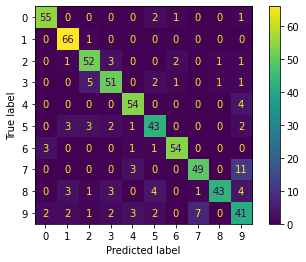

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train_subset, y_train_subset_pred)
